In [1]:
from functools import partial
from itertools import islice
from operator import itemgetter
from pathlib import Path
from typing import Tuple

import einops
import multi_object_datasets.clevr_with_masks
import numpy as np
import osc.data.clevr_with_masks
import tensorflow as tf
import torch
import torchvision as tv
import tqdm
from IPython.display import Image, display
from osc.data.random_resized_crop import random_resized_crop
from osc.data.utils import (
    augment_train,
    augment_twice,
    augment_val,
    img_hwc_to_chw,
    normalize_tf,
    unnormalize_pt,
    wrap_with_seed,
)
from osc.utils import print_arrays
from PIL import Image

SEED = 0
IMG_MEAN = (0.485, 0.456, 0.406)
IMG_STD = (0.229, 0.224, 0.225)

num_epochs = 3
batch_size = 4
max_samples = 2 * batch_size
img_size = (128, 128)

tfr_path = (
    Path.home()
    / "multi-object-datasets"
    / "clevr_with_masks"
    / "clevr_with_masks_train.tfrecords"
)

## No augmentations

No augmentations, num objects <= 4

2022-02-04 18:33:33.993264: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-04 18:33:34.235481: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


  name  dtype          shape
------  -------------  ----------------
     0  torch.float32  [4, 3, 240, 320]


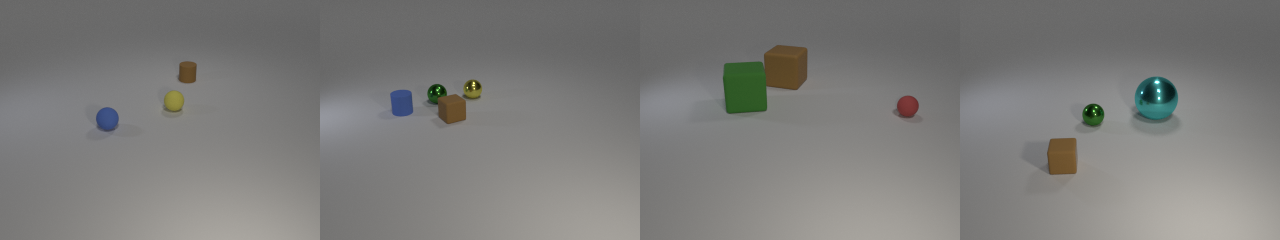

  name  dtype          shape
------  -------------  ----------------
     0  torch.float32  [4, 3, 240, 320]


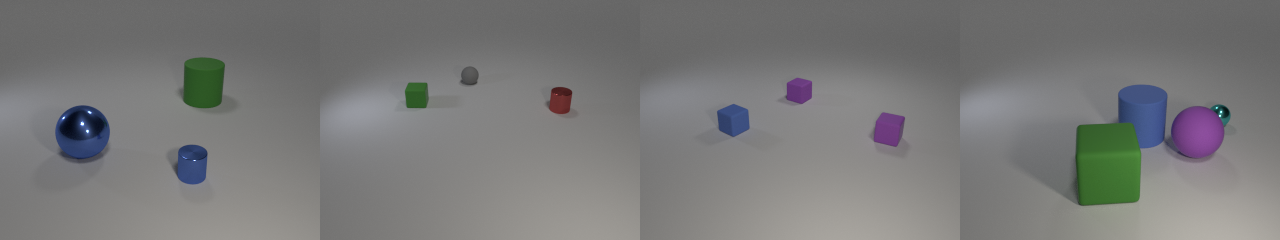

In [2]:
ds = (
    tf.data.TFRecordDataset(tfr_path.as_posix(), compression_type="GZIP")
    .map(
        multi_object_datasets.clevr_with_masks._decode,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )
    .filter(lambda sample: tf.reduce_sum(sample["visibility"]) <= 4 + 1)
    .take(max_samples)
    .map(itemgetter("image"))
    .map(lambda x: tf.image.convert_image_dtype(x, tf.float32))
    .map(partial(normalize_tf, mean=IMG_MEAN, std=IMG_STD))
    .map(img_hwc_to_chw)
    .batch(batch_size)
    .take(2)
)

for images in ds.as_numpy_iterator():
    images = torch.from_numpy(np.copy(images))
    print_arrays(images)
    display(
        tv.transforms.functional.to_pil_image(
            einops.rearrange(
                unnormalize_pt(images, IMG_MEAN, IMG_STD), "B C H W -> C H (B W)"
            )
        )
    )

## With augmentations (train)

Check that in each epoch:
- the order of images is shuffled
- the augmentations are different

Epoch 0
name     dtype          shape
-------  -------------  -------------------
Batch 0  torch.float32  [2, 4, 3, 128, 128]


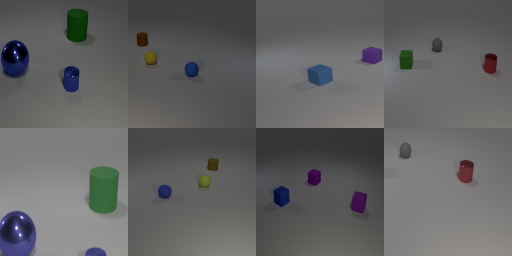

name     dtype          shape
-------  -------------  -------------------
Batch 1  torch.float32  [2, 4, 3, 128, 128]


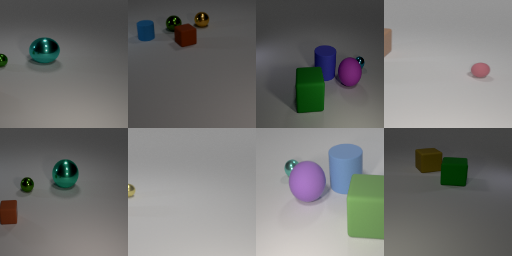

Epoch 1
name     dtype          shape
-------  -------------  -------------------
Batch 0  torch.float32  [2, 4, 3, 128, 128]


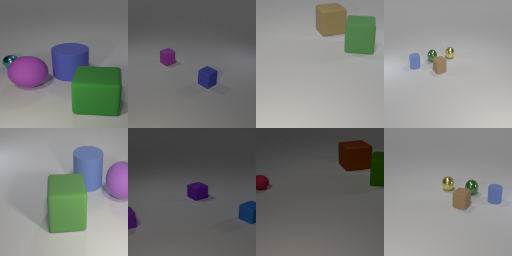

name     dtype          shape
-------  -------------  -------------------
Batch 1  torch.float32  [2, 4, 3, 128, 128]


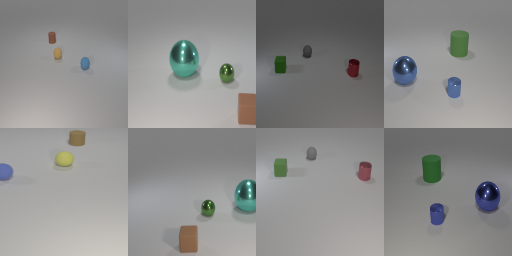

Epoch 2
name     dtype          shape
-------  -------------  -------------------
Batch 0  torch.float32  [2, 4, 3, 128, 128]


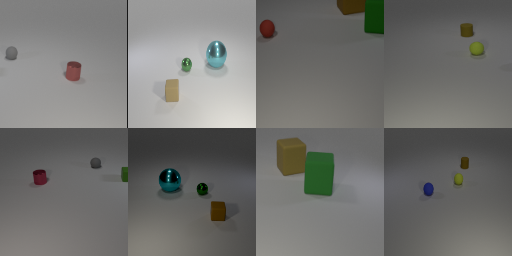

name     dtype          shape
-------  -------------  -------------------
Batch 1  torch.float32  [2, 4, 3, 128, 128]


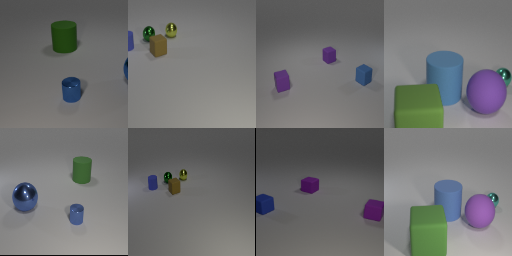

In [4]:
ds_aug = (
    tf.data.TFRecordDataset(tfr_path.as_posix(), compression_type="GZIP")
    # Decode example dict
    .map(
        multi_object_datasets.clevr_with_masks._decode,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )
    # Select samples with at most 4 objects
    .filter(lambda sample: tf.reduce_sum(sample["visibility"]) <= 4 + 1)
    # Limit number of samples per epoch
    .take(max_samples)
    # Choose 'image' feature, discard rest
    .map(itemgetter("image"))
    # Shuffle using a buffer
    .shuffle(min(10, max_samples // batch_size) * batch_size, seed=SEED)
    # Augment twice [H W C] -> ([C H W], [C H W])
    .map(
        augment_twice(
            wrap_with_seed(
                partial(augment_train, crop_size=img_size, mean=IMG_MEAN, std=IMG_STD),
                initial_seed=SEED,
            ),
            wrap_with_seed(
                partial(augment_train, crop_size=img_size, mean=IMG_MEAN, std=IMG_STD),
                initial_seed=SEED + 1,
            ),
        )
    )
    # Batch: B x ([C H W], [C H W]) -> ([B C H W], [B C H W])
    .batch(batch_size, drop_remainder=True)
    # Stack augmented batches ([B C H W], [B C H W]) -> [A B C H W]
    .map(lambda b0, b1: tf.stack([b0, b1], axis=0))
    # Add batch idx
    .enumerate()
    # Repeat per epoch
    .repeat(num_epochs)
    # Other stuff
    .as_numpy_iterator()
)

for epoch in range(num_epochs):
    if epoch > 0:
        print("===" * 25)
    print("Epoch", epoch)

    for batch_idx, images in islice(ds_aug, max_samples // batch_size):
        images = torch.from_numpy(np.copy(images))
        print_arrays({f"Batch {batch_idx}": images})
        display(
            tv.transforms.functional.to_pil_image(
                einops.rearrange(
                    unnormalize_pt(images, IMG_MEAN, IMG_STD),
                    "A B C H W -> C (A H) (B W)",
                )
            )
        )

## With augmentations (val)

Check that in each epoch:
- the order of images is the same
- the augmentations are the same

Epoch 0
name     dtype          shape
-------  -------------  -------------------
Batch 0  torch.float32  [2, 4, 3, 128, 128]


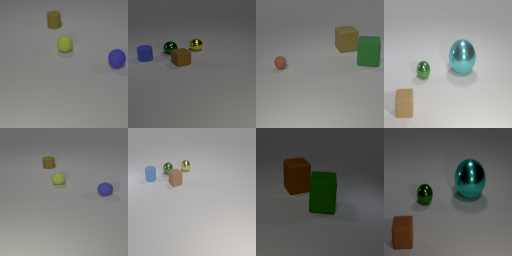

name     dtype          shape
-------  -------------  -------------------
Batch 1  torch.float32  [2, 4, 3, 128, 128]


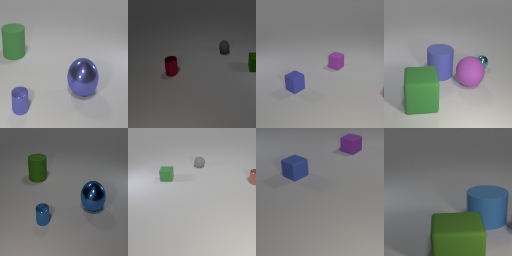

Epoch 1
name     dtype          shape
-------  -------------  -------------------
Batch 0  torch.float32  [2, 4, 3, 128, 128]


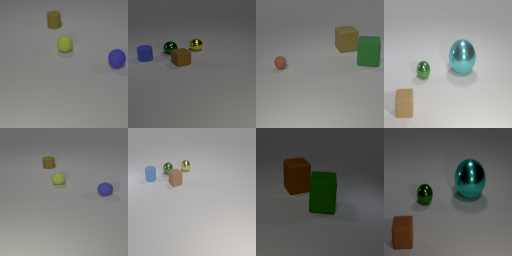

name     dtype          shape
-------  -------------  -------------------
Batch 1  torch.float32  [2, 4, 3, 128, 128]


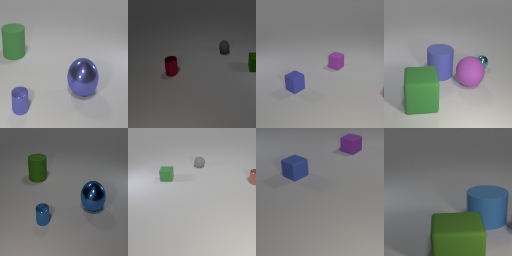

Epoch 2
name     dtype          shape
-------  -------------  -------------------
Batch 0  torch.float32  [2, 4, 3, 128, 128]


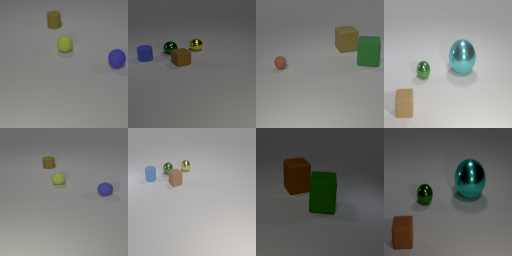

name     dtype          shape
-------  -------------  -------------------
Batch 1  torch.float32  [2, 4, 3, 128, 128]


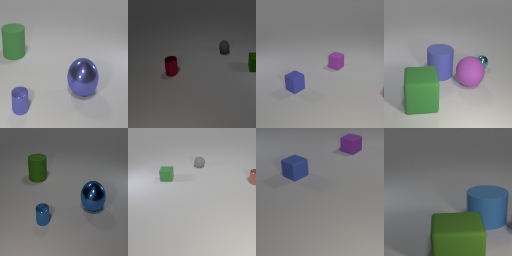

In [4]:
ds_aug = (
    # Zip with two random sequences to get per-image random seeds
    # that repeat identically at every epoch
    tf.data.Dataset.zip((
        tf.data.TFRecordDataset(tfr_path.as_posix(), compression_type="GZIP")
        # Decode example dict
        .map(
            multi_object_datasets.clevr_with_masks._decode,
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=True,
        )
        # Select samples with at most 4 objects
        .filter(lambda sample: tf.reduce_sum(sample["visibility"]) <= 4 + 1)
        # Limit number of samples per epoch
        .take(max_samples)
        # Choose 'image' feature, discard rest
        .map(itemgetter("image")),
        tf.data.Dataset.random(SEED),
        tf.data.Dataset.random(SEED+1),
    ))
    # Augment twice [H W C] -> ([C H W], [C H W])
    .map(
        lambda img, s0, s1:
        (
            augment_train(img, seed=[s0, 0], crop_size=img_size, mean=IMG_MEAN, std=IMG_STD),
            augment_train(img, seed=[s1, 0], crop_size=img_size, mean=IMG_MEAN, std=IMG_STD),
        )
    )
    # Batch: B x ([C H W], [C H W]) -> ([B C H W], [B C H W])
    .batch(batch_size, drop_remainder=True)
    # Stack augmented batches ([B C H W], [B C H W]) -> [A B C H W]
    .map(lambda b0, b1: tf.stack([b0, b1], axis=0))
    # Add batch idx
    .enumerate()
    # Repeat per epoch
    .repeat(num_epochs)
    # Other stuff
    .as_numpy_iterator()
)

# Check that in each epoch:
# - the order of images is shuffled
# - the augmentations are different

for epoch in range(num_epochs):
    if epoch > 0:
        print("===" * 25)
    print("Epoch", epoch)

    for batch_idx, images in islice(ds_aug, max_samples // batch_size):
        images = torch.from_numpy(np.copy(images))
        print_arrays({f"Batch {batch_idx}": images})
        display(
            tv.transforms.functional.to_pil_image(
                einops.rearrange(
                    unnormalize_pt(images, IMG_MEAN, IMG_STD),
                    "A B C H W -> C (A H) (B W)",
                )
            )
        )

## Speed test (original TFRecords)

Simulate training conditions:
- Do not filter by object count
- Shuffle buffer is filled every epoch

In [11]:
num_epochs = 5
batch_size = 32
max_samples = 100 * batch_size

ds_aug = (
    tf.data.TFRecordDataset(tfr_path.as_posix(), compression_type="GZIP")
    # Limit number of samples per epoch
    .take(max_samples)
    # Decode example dict
    .map(
        multi_object_datasets.clevr_with_masks._decode,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )
    # Choose 'image' feature, discard rest
    .map(itemgetter("image"))
    # Shuffle using a buffer
    .shuffle(min(10, max_samples // batch_size) * batch_size, seed=SEED)
    # Augment twice [H W C] -> ([C H W], [C H W])
    .map(
        augment_twice(
            wrap_with_seed(
                partial(augment_train, crop_size=img_size, mean=IMG_MEAN, std=IMG_STD),
                initial_seed=SEED,
            ),
            wrap_with_seed(
                partial(augment_train, crop_size=img_size, mean=IMG_MEAN, std=IMG_STD),
                initial_seed=SEED + 1,
            ),
        ),
    )
    # Batch: B x ([C H W], [C H W]) -> ([B C H W], [B C H W])
    .batch(batch_size, drop_remainder=True)
    # Stack augmented batches ([B C H W], [B C H W]) -> [A B C H W]
    .map(lambda b0, b1: tf.stack([b0, b1], axis=0))
    # Add batch idx
    .enumerate()
    # Repeat per epoch
    .repeat(num_epochs)
    # Other stuff
    .prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
)

for _, images in tqdm.tqdm(ds_aug, unit=" imgs", unit_scale=batch_size):
    images = torch.from_numpy(np.copy(images))

16000 imgs [02:25, 110.23 imgs/s]


## TFRecords of images only

train: 70000 imgs [28:39, 40.71 imgs/s]


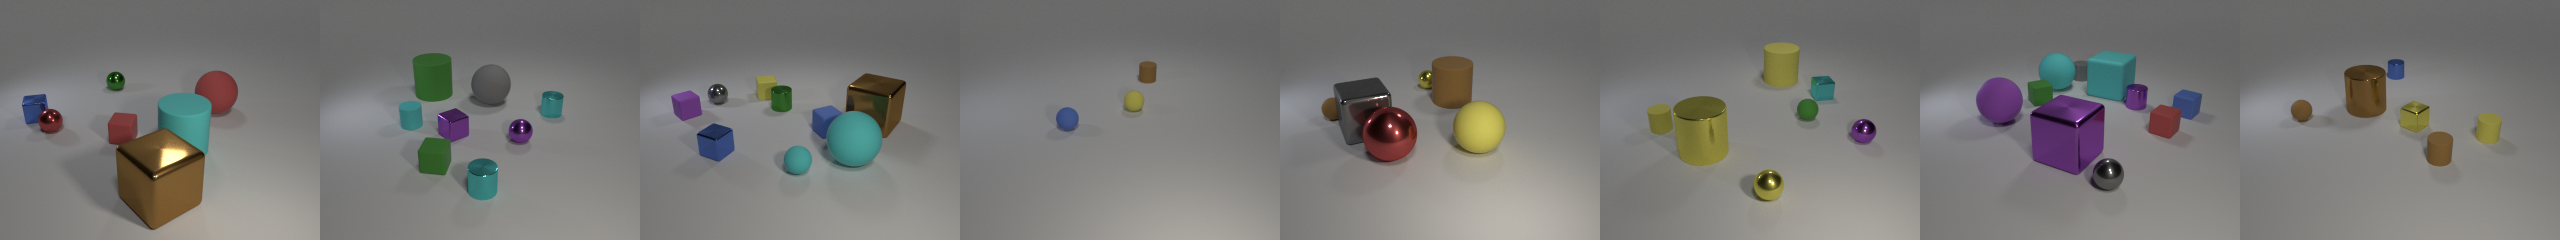

val: 15000 imgs [06:08, 40.72 imgs/s]


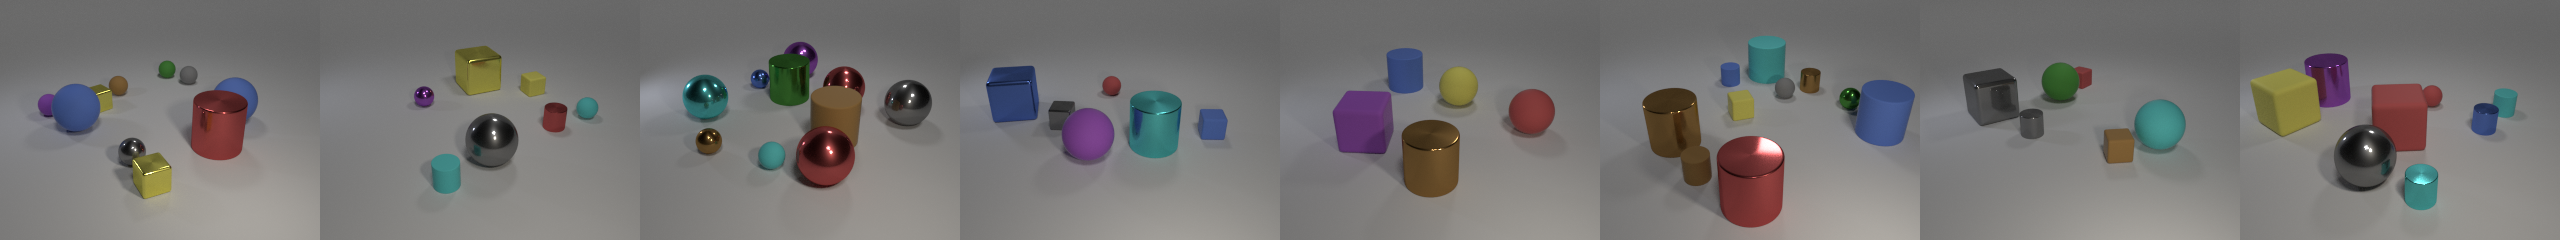

In [5]:
def serialize_image(image):
    feature = {
        "image": tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(image).numpy()])
        )
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()


@tf.function
def deserialize_image(example, *, img_size: Tuple[int, int]):
    example = tf.io.parse_single_example(
        example, {"image": tf.io.FixedLenFeature([], tf.string)}
    )
    image = tf.io.parse_tensor(example["image"], tf.uint8)
    image = tf.ensure_shape(image, (*img_size, 3))
    return image


ds = (
    tf.data.TFRecordDataset(tfr_path.as_posix(), compression_type="GZIP")
    .map(
        multi_object_datasets.clevr_with_masks._decode,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )
    .map(
        lambda example: tf.py_function(serialize_image, (example["image"],), tf.string),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )
    .as_numpy_iterator()
)

for split, num_samples in [
    ("train", osc.data.clevr_with_masks.NUM_SAMPLES_TRAIN),
    ("val", osc.data.clevr_with_masks.NUM_SAMPLES_VAL),
]:
    dst_path = Path.as_posix(tfr_path.parent / f"imgs_{split}.tfrecords")

    with tf.io.TFRecordWriter(dst_path, options="GZIP") as writer:
        for example in tqdm.tqdm(islice(ds, num_samples), desc=split, unit=" imgs"):
            writer.write(example)

    # Test read
    images = (
        tf.data.TFRecordDataset(dst_path, compression_type="GZIP")
        .map(partial(deserialize_image, img_size=osc.data.clevr_with_masks))
        .batch(8)
        .take(1)
        .get_single_element()
        .numpy()
    )
    display(Image.fromarray(einops.rearrange(images, "B H W C -> H (B W) C")))

## Speed test 2

Read from image-only TFRecords.

Simulate training conditions:
- Do not filter by object count
- Shuffle buffer is filled every epoch

In [14]:
num_epochs = 5
batch_size = 32
max_samples = 100 * batch_size

ds_aug = (
    tf.data.TFRecordDataset(
        Path.as_posix(tfr_path.parent / f"imgs_train.tfrecords"),
        compression_type="GZIP",
    )
    # Limit number of samples per epoch
    .take(max_samples)
    # Decode image
    .map(
        partial(deserialize_image, img_size=osc.data.clevr_with_masks.IMAGE_SIZE),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )
    # Shuffle using a buffer
    .shuffle(min(10, max_samples // batch_size) * batch_size, seed=SEED)
    # Augment twice [H W C] -> ([C H W], [C H W])
    .map(
        augment_twice(
            wrap_with_seed(
                partial(augment_train, crop_size=img_size, mean=IMG_MEAN, std=IMG_STD),
                initial_seed=SEED,
            ),
            wrap_with_seed(
                partial(augment_train, crop_size=img_size, mean=IMG_MEAN, std=IMG_STD),
                initial_seed=SEED + 1,
            ),
        ),
    )
    # Batch: B x ([C H W], [C H W]) -> ([B C H W], [B C H W])
    .batch(batch_size, drop_remainder=True)
    # Stack augmented batches ([B C H W], [B C H W]) -> [A B C H W]
    .map(lambda b0, b1: tf.stack([b0, b1], axis=0))
    # Add batch idx
    .enumerate()
    # Repeat per epoch
    .repeat(num_epochs)
    # Other stuff
    .prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
)

for _, images in tqdm.tqdm(ds_aug, unit=" imgs", unit_scale=batch_size):
    images = torch.from_numpy(np.copy(images))

16000 imgs [01:22, 194.65 imgs/s]
